# FMNIST Classification using ANN

### About the Dataset

Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. We intend Fashion-MNIST to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits. 
[More info.](https://github.com/zalandoresearch/fashion-mnist)

### Why Fashion-MNIST over MNIST?
- MNIST is too easy. Convolutional nets can achieve 99.7% on MNIST. Classic machine learning algorithms can also achieve 97% easily.
- MNIST is overused.
- MNIST can not represent modern CV tasks.

Let's now get going with it.

## 1. Importing packages.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

## 2. Downloading Dataset and applying Transformations.

In [2]:
# defining the transformations (converting the image into tensors).
transform = transforms.Compose([transforms.ToTensor()])

The Dataset could have been normalised, but as all the pixel values(features) range from 0 to 255, normalising the data doesn't seem necessary.

In [3]:
# trainset and testset
train_set = datasets.FashionMNIST(
    root = './data/FMNIST',
    train = True,
    download = True,
    transform = transform
)

test_set = datasets.FashionMNIST(
    root = './data/FMNIST',
    train = False,
    download = True,
    transform = transform
)

In [4]:
print(f'Train set : {len(train_set)}')
print(f'Test set : {len(test_set)}')

Train set shape : 60000
Test set shape : 10000


## 3. Exploring the data

In [5]:
from torch.utils.data import DataLoader
# Loading data into a DataLoader of batch size 64
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)

In [6]:
# Unpacking the images and labels of a batch
images, labels = next(iter(train_loader))

Let's check the shapes of our images and labels.

In [7]:
print("Images' Shape : ", images.shape)
print("Labels' Shape : ", labels.shape)

Images' Shape :  torch.Size([64, 1, 28, 28])
Labels' Shape :  torch.Size([64])


The shape of the `images` tensor denotes the no of training examples in the batch, the no of color channels in the batch, and finally the height and width of every image.

The shape of the `labels` tensor is 64, as the labels contains the digit corresponding to the fashion item(ground-truth) for every single image in the dataset.

Let's see what the numbers in the labels in the dataset represent.

<table>
<thead>
<tr>
<th>Label</th>
<th>Description</th>
</tr>
</thead>
<tbody>
<tr>
<td>0</td>
<td>T-shirt/top</td>
</tr>
<tr>
<td>1</td>
<td>Trouser</td>
</tr>
<tr>
<td>2</td>
<td>Pullover</td>
</tr>
<tr>
<td>3</td>
<td>Dress</td>
</tr>
<tr>
<td>4</td>
<td>Coat</td>
</tr>
<tr>
<td>5</td>
<td>Sandal</td>
</tr>
<tr>
<td>6</td>
<td>Shirt</td>
</tr>
<tr>
<td>7</td>
<td>Sneaker</td>
</tr>
<tr>
<td>8</td>
<td>Bag</td>
</tr>
<tr>
<td>9</td>
<td>Ankle boot</td>
</tr>
</tbody>
</table>

Let's now see how the images look like along with their truth labels.

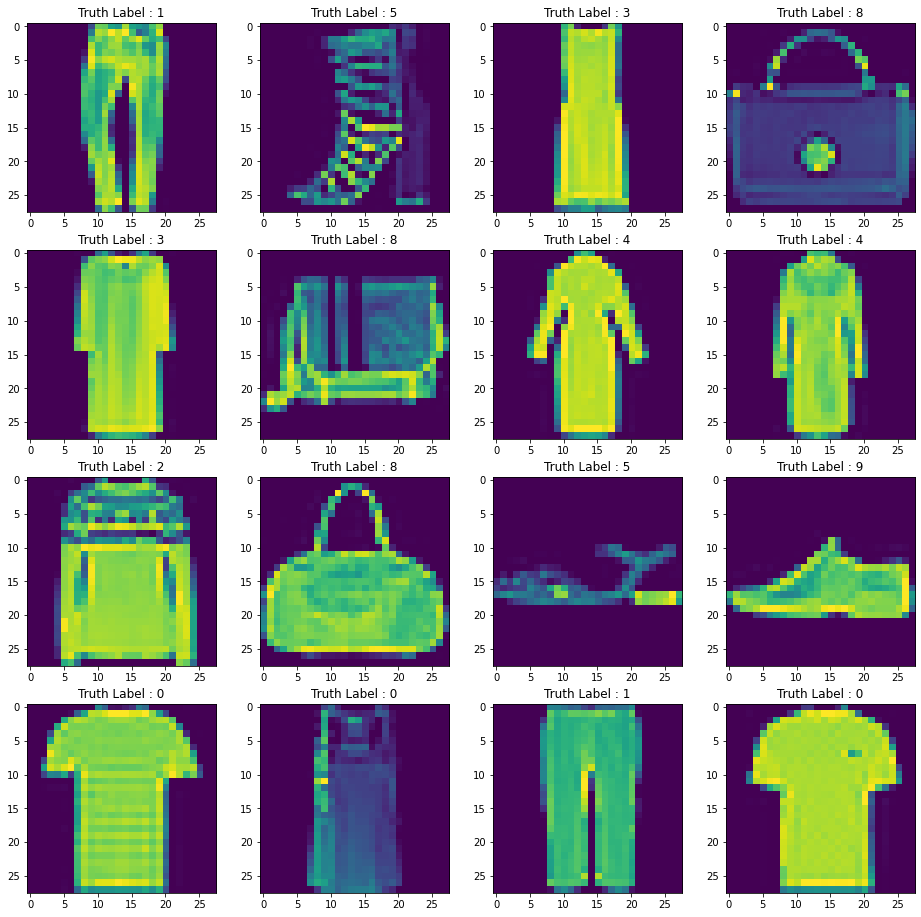

In [8]:
from IPython.core.pylabtools import figsize
# creating subplots 4x4 grid
fig, ax = plt.subplots(4,4, figsize=(16,16))

index = 0
for i in range(4):
    for j in range(4):
        ax[i,j].imshow(images[index].squeeze())
        ax[i,j].set_title(f'Truth Label : {labels[index].item()}')
        index+=1

## 4. Designing the Neural Network

The input layer consists of 28x28 neurons(= the no of pixels in each image) and the output layer consistes of 10 neurons(= no of classes). The Neural Network also consists of 2 hidden layer with 128 and 64 neurons respectively.

In [9]:
# no of neurons in respective layers
input_sizes = 28*28
output_sizes = 10
hidden_sizes = [128, 64]

In [10]:
class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        
        self.linear1 = nn.Linear(in_features=input_sizes, out_features=hidden_sizes[0])       # 784 -> 128
        self.linear2 = nn.Linear(in_features=hidden_sizes[0], out_features=hidden_sizes[1])   # 128 -> 64
        self.out = nn.Linear(in_features=hidden_sizes[1], out_features=output_sizes)          # 64  -> 10
        
    def forward(self, t):
         # (1) input layer
        t = t 
        
        # (2) hidden layer 1
        t = self.linear1(t)
        t = F.relu(t)
        
        # (3) hidden layer 2
        t = self.linear2(t)
        t = F.relu(t)
        
        # (4) output layer
        t = self.out(t)
        
        return t

In [11]:
network_trial = ANN()

In [12]:
print(network_trial)

ANN(
  (linear1): Linear(in_features=784, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (out): Linear(in_features=64, out_features=10, bias=True)
)


Inside the network we usually use `relu()` as our non-linear activation function, but for the output layer, whenever we have a single category that we are trying to predict, we use `softmax()`. The softmax function returns a positive probability for each of the prediction classes, and the probabilities sum to 1.
However, in our case, we won't use `softmax()` because the loss function that we'll use, `nn.CrossEntropyLoss()`, implicitly performs the `softmax()` operation on its input, so we'll just return the result of the last linear transformation.

## 5. The Training Process

In [13]:
def get_num_correct(pred, labels):
    '''Returns number of labels predicted corrected'''
    return pred.argmax(dim=1).eq(labels).sum().item()

Getting ready for the training process, setting `hyperparameters`, `loss function` and `optimizer`.\
We will be trying out various values of our Hyperparameters, `learning_rates`, `batch_sizes`, `shuffle` and `devices` to get the best model.

In [14]:
from itertools import product

parameters = dict(
    lr = [.01, .001],
    batch_size = [100, 1000],
    shuffle = [True]
)
epochs = 20
param_values = [v for v in parameters.values()]

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# selecting the loss function
criterion = nn.CrossEntropyLoss()

# creating a list of model for various sets of hyperparameter combination
networks = []

#### The Training Loop

The images have to be flattened out before feeding it to the ANN. Then, the batch is fed into the network. The outputs of the network is fed into the loss function with the truth labels. Then, the old gradients (from the previous iterations) are forced to 0 and backprop starts. The optimizer updates the weights at each iteration.

In [15]:
index = 0
for lr, batch_size, shuffle in product(*param_values):

    print(f'\nModel {index} : Batch size : {batch_size}, Learning Rate : {lr} Shuffle : {shuffle}\n')
    # using the dataloader to load batches of data
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=shuffle)
    
    device = torch.device(device)
    network = ANN().to(device)
    networks.append(network)
    index+=1
    
    # selecting the optimizer for the loss function
    optimizer = optim.Adam(network.parameters(), lr=lr)

    for epoch in range(epochs):
        total_loss=0
        total_correct=0
        for batch in train_loader:
            images = batch[0].to(device)
            labels = batch[1].to(device)
            # flattening the 3d image into a 1d vector
            images = images.view(images.shape[0], -1)
            
            # Forward Prop
            outputs = network(images)
            loss = criterion(outputs, labels)
            
            optimizer.zero_grad() # making previous grads 0
            loss.backward() # Calculate Gradients / Back Prop
            optimizer.step() # Update Weights
            
            total_loss += loss.item() # total loss over batches
            # the total loss has to be divided by `len(batches)` for the correct value
            total_correct += get_num_correct(outputs, labels)
        
        print(f'Epoch {epoch} - Training Loss : {total_loss/len(train_loader)}, Accuracy : {total_correct / len(train_set)}')


Model 0 : Batch size : 100, Learning Rate : 0.01 Shuffle : True

Epoch 0 - Training Loss : 0.5139053584138552, Accuracy : 0.8112
Epoch 1 - Training Loss : 0.39604434827963514, Accuracy : 0.8564333333333334
Epoch 2 - Training Loss : 0.3666242829710245, Accuracy : 0.8658166666666667
Epoch 3 - Training Loss : 0.35480564296245576, Accuracy : 0.8711166666666667
Epoch 4 - Training Loss : 0.3376127040634553, Accuracy : 0.8766333333333334
Epoch 5 - Training Loss : 0.33497414072354637, Accuracy : 0.8777333333333334
Epoch 6 - Training Loss : 0.3288186920558413, Accuracy : 0.8811
Epoch 7 - Training Loss : 0.32000288980702557, Accuracy : 0.88365
Epoch 8 - Training Loss : 0.3157011655593912, Accuracy : 0.8846666666666667
Epoch 9 - Training Loss : 0.3060189051926136, Accuracy : 0.8876833333333334
Epoch 10 - Training Loss : 0.3064986673121651, Accuracy : 0.8889666666666667
Epoch 11 - Training Loss : 0.29900732504824795, Accuracy : 0.88995
Epoch 12 - Training Loss : 0.2969070319086313, Accuracy : 0.8

The training accuracy of the model with `Batch size : 100, Learning Rate : 0.001 Shuffle : True` in `20 epochs` is already `92.7 %`. The model seems to be good enough.

Let's evaluate the `Model 2` on the test set now.

In [22]:
networks[2]

ANN(
  (linear1): Linear(in_features=784, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (out): Linear(in_features=64, out_features=10, bias=True)
)

## 6. Evaluating the network

Using the test_loader to generate batches of test data and test the `Model 2` with it.

In [28]:
test_loader = DataLoader(test_set, batch_size=64, shuffle=True)

In [29]:
correct_count = 0

for images, labels in test_loader:
    for i in range(len(labels)):
        # getting individual images in the particular test loader and flattening it
        image = images[i].view(1, 784)
        # turning off gradients to save computation
        with torch.no_grad():
            outputs = networks[2](image) # taking model 2 from list of models
        # squeezing the dimension of the output tensor from [[]] to []
        outputs = list(outputs.squeeze())
        # taking agrmax of the output and setting it as the predicted label
        pred_label = outputs.index(max(outputs))
        true_label = labels[i]
        
        if(true_label == pred_label):
            correct_count += 1
        
print("Test Accuracy =", (correct_count/len(test_set)))

Test Accuracy = 0.8835


The test accuracy is about `88 %` which is good, but can we do it better?

We will try this same classification with the Convolutional Neural Network next.
Bye for Now!

# The End